In [2]:
# Import libraries and supress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Use Agg backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensuring backend for plt if only plt is imported

%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Display settings
sns.set(style='whitegrid', palette='muted', color_codes=True)

In [3]:
# Load the hotel reservations dataset
file_path = 'D:\\python\\MachineLearning\\hotel reservation\\Hotel Reservations.csv'
df = pd.read_csv(file_path, delimiter=',', encoding='ascii')

# Show the first few rows of the dataset
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
# Combine arrival date information into a single datetime column
try:
    df['arrival_datetime'] = pd.to_datetime(df['arrival_year'].astype(str) + '-' 
                                           + df['arrival_month'].astype(str) + '-' 
                                           + df['arrival_date'].astype(str),
                                           format='%Y-%m-%d')
except Exception as e:
    print('Error while combining date columns:', e)

# Check for missing values
missing_values = df.isnull().sum()
print('Missing values per column:')
print(missing_values)

# Optional: Fill missing values if needed (here, we assume no missing values for simplicity)

# Convert categorical columns to appropriate types
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print('Categorical columns:', categorical_columns)

Error while combining date columns: day is out of range for month, at position 492. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Missing values per column:
Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     

Exploratory Data Analysis


Let's uncover some interesting patterns. We will create several plots:


A histogram for numeric distributions

A count plot (pie-like chart) for the target variable booking_status

A pair plot for important numeric columns (if there are enough numeric features)

A correlation heatmap of numeric features (only if there are four or more numeric columns)

Box, boxen, violin, and strip plots for further distribution insights

Note: The choice of visualizations is partly an art; enjoy the craft.

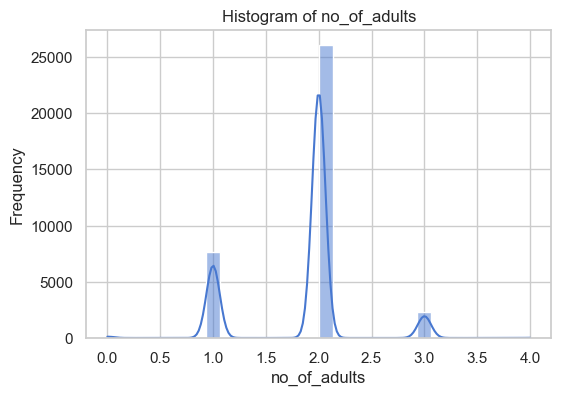

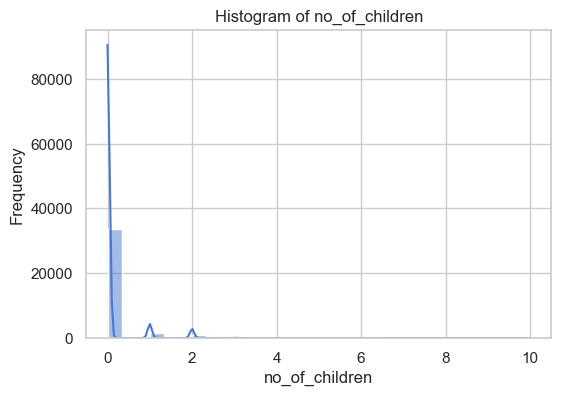

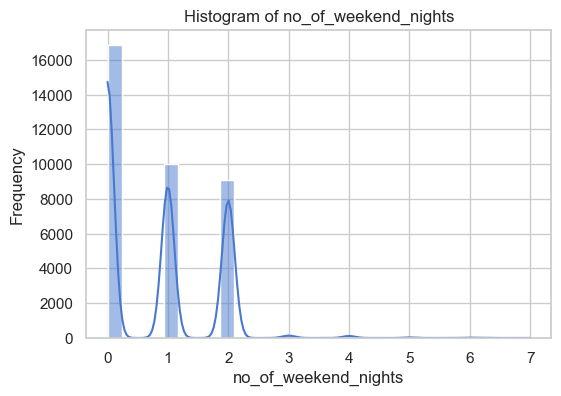

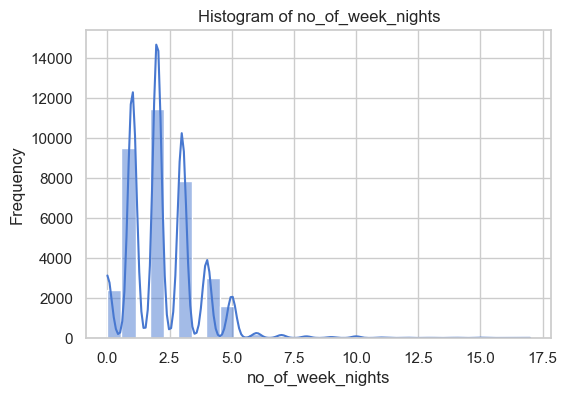

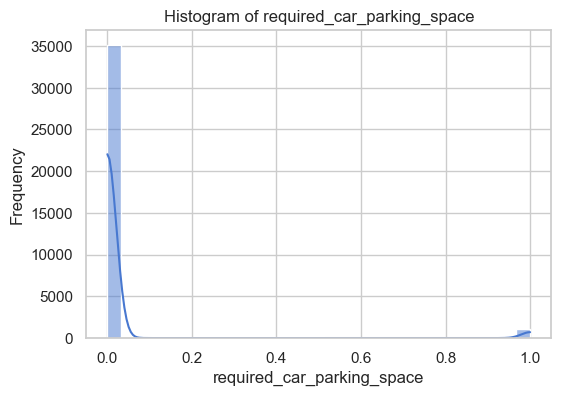

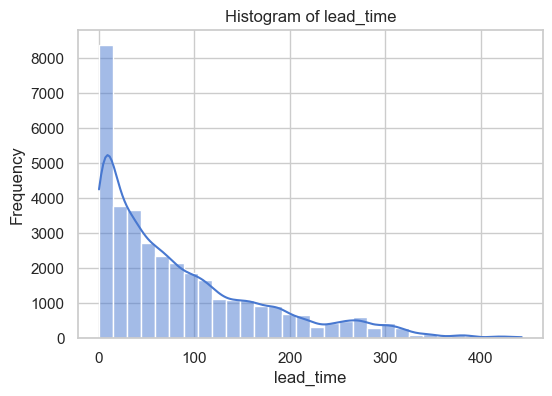

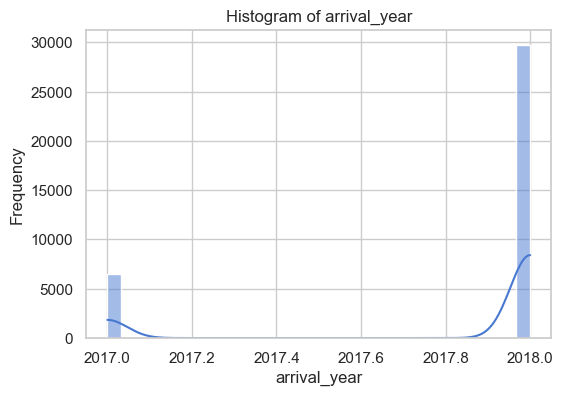

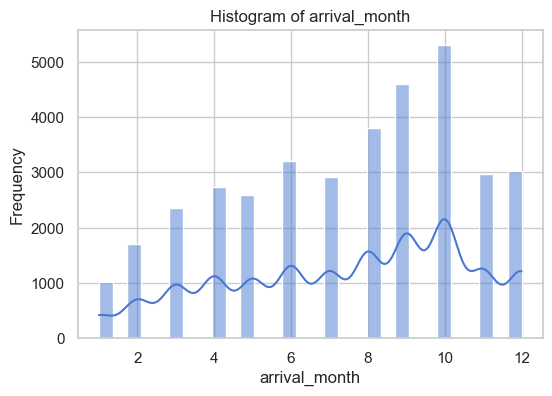

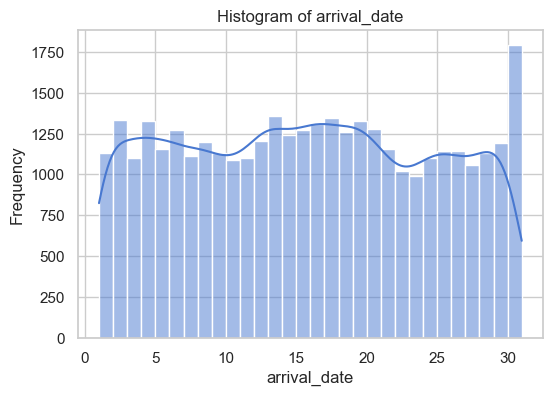

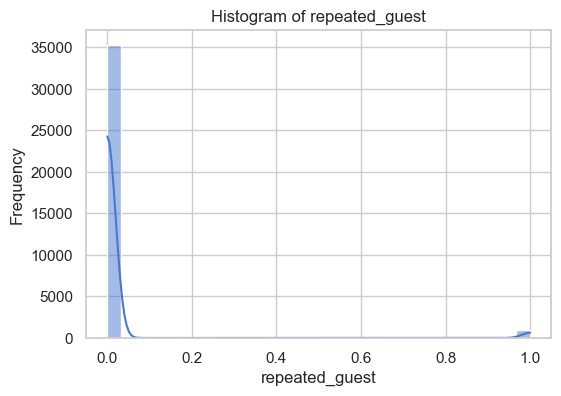

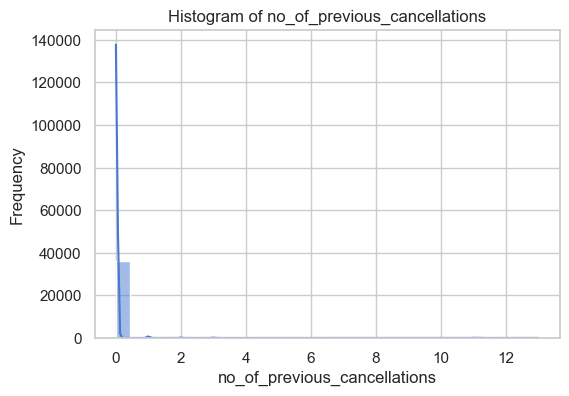

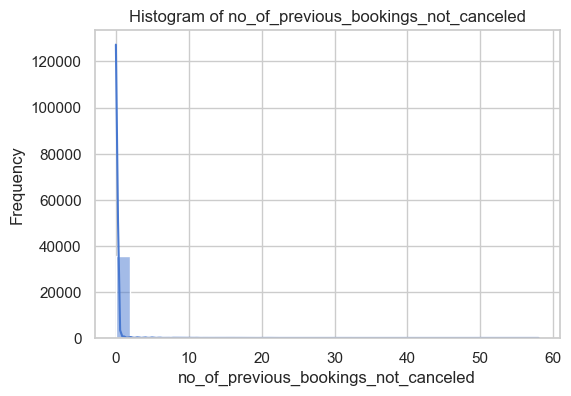

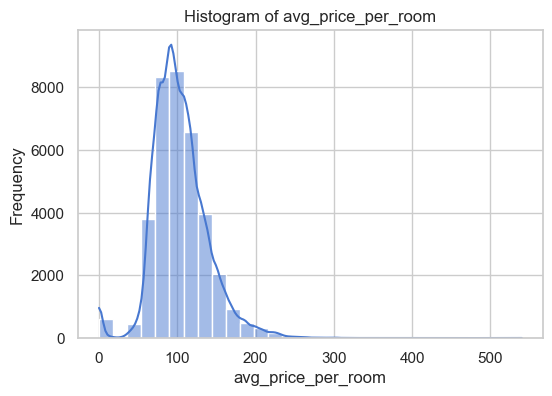

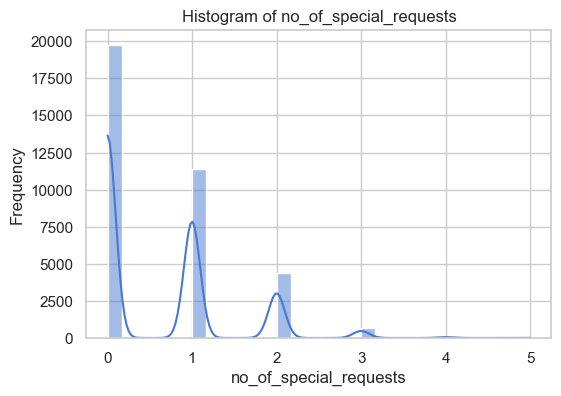

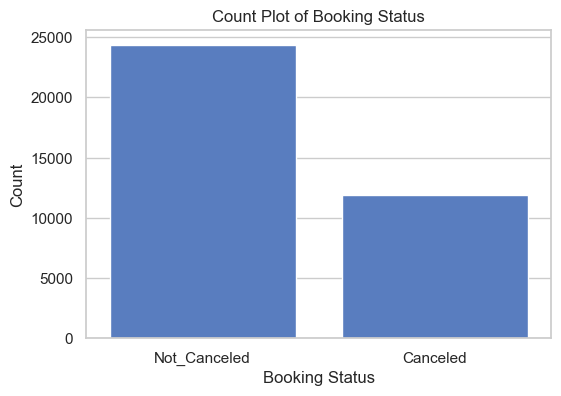

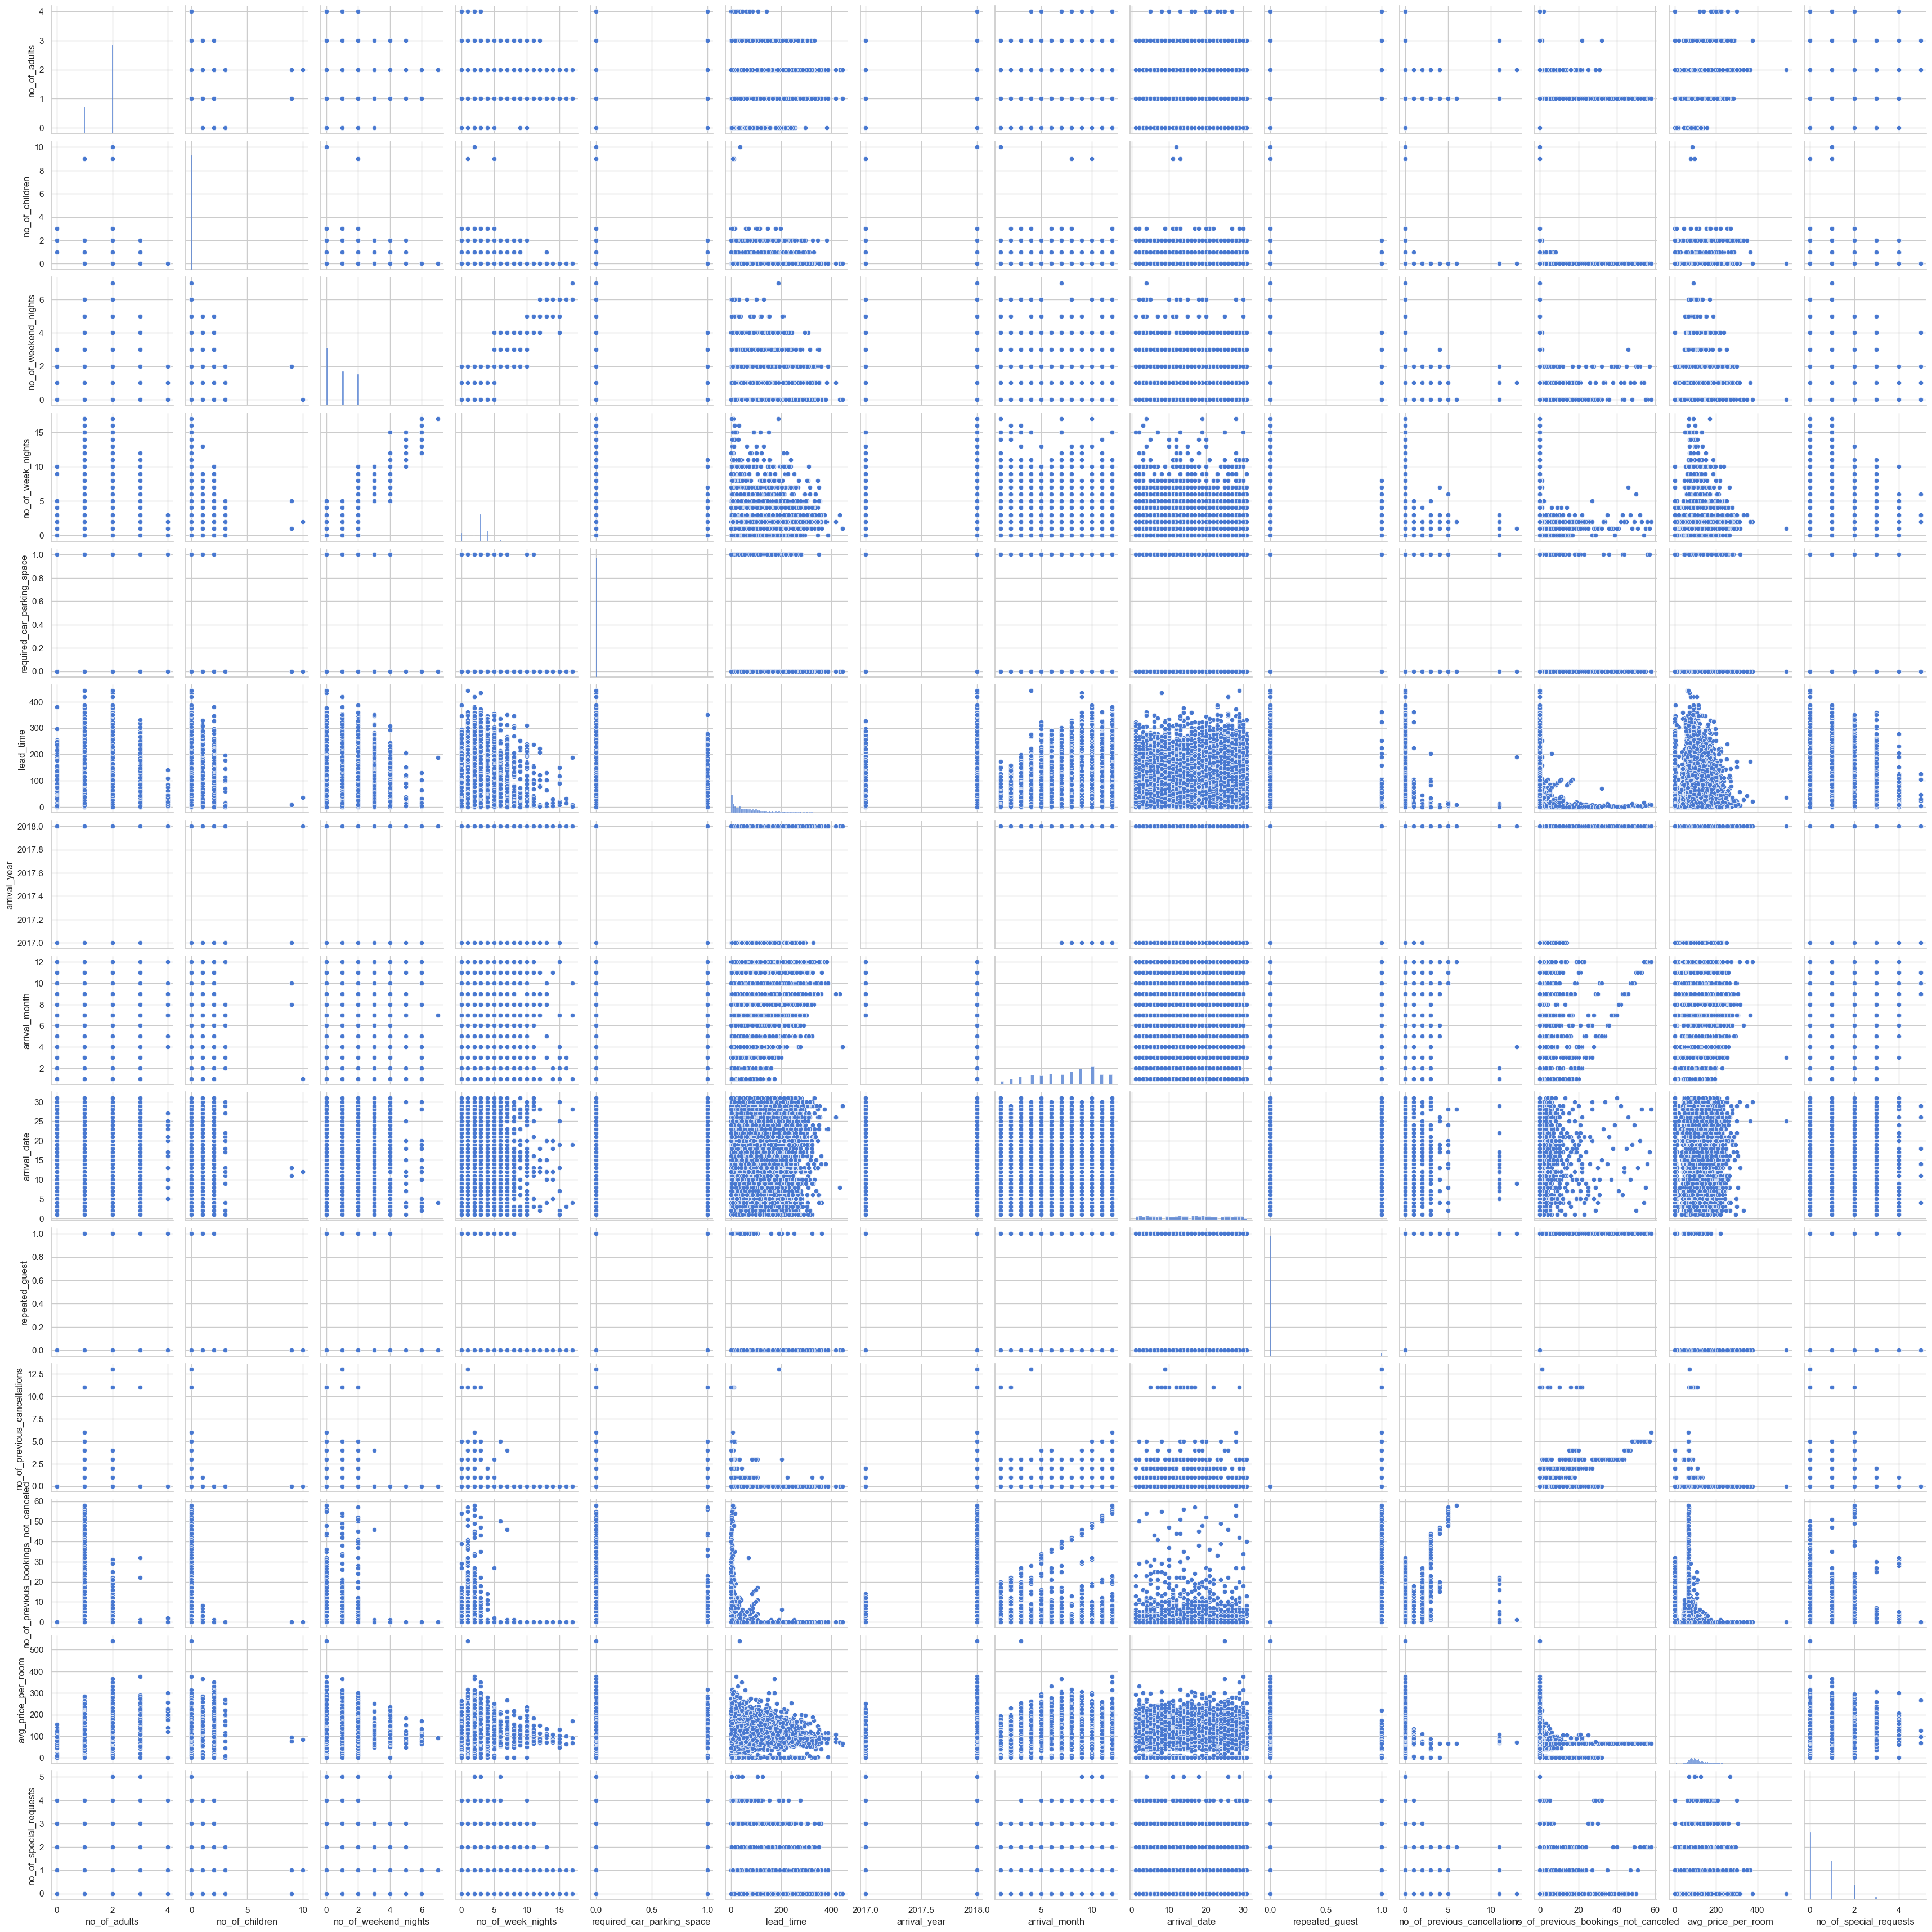

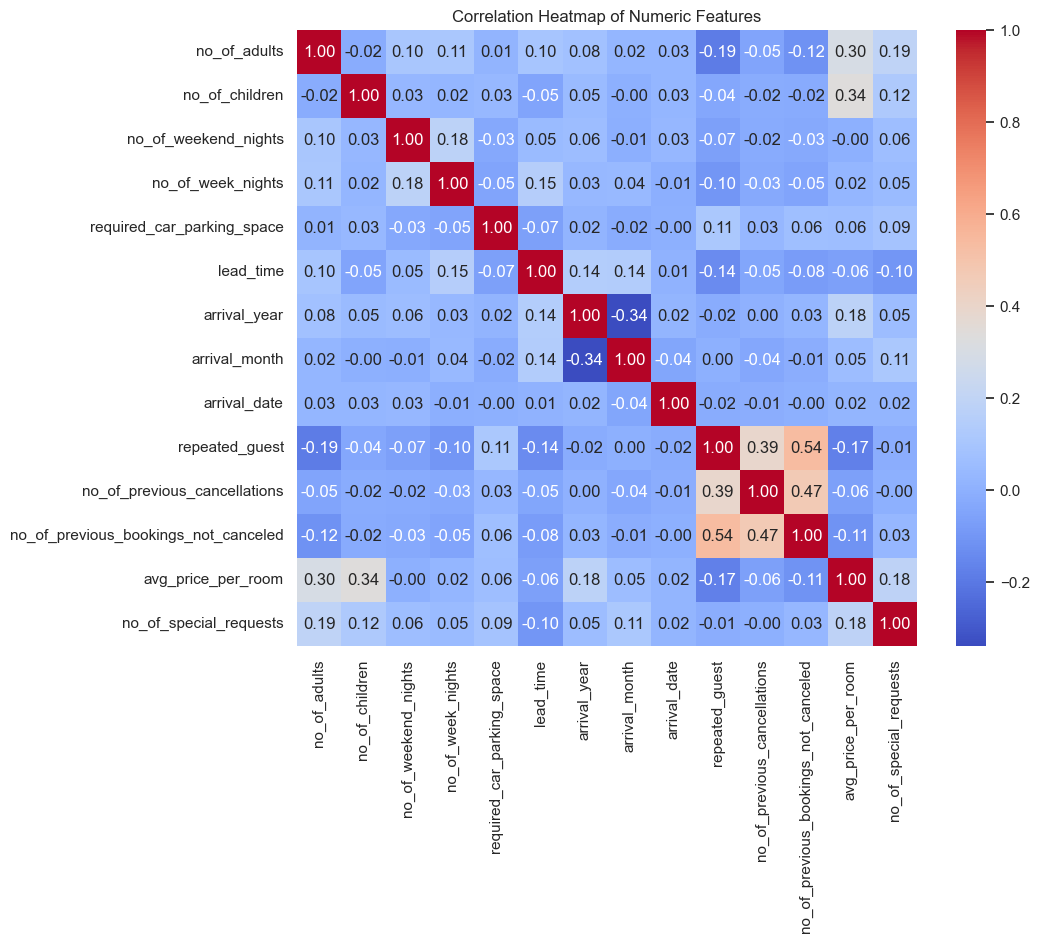

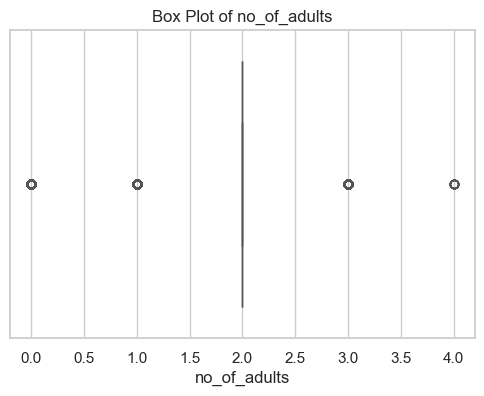

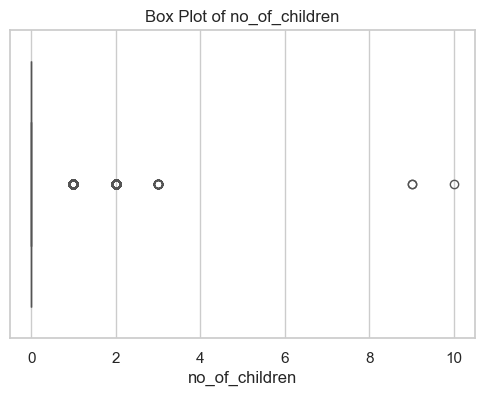

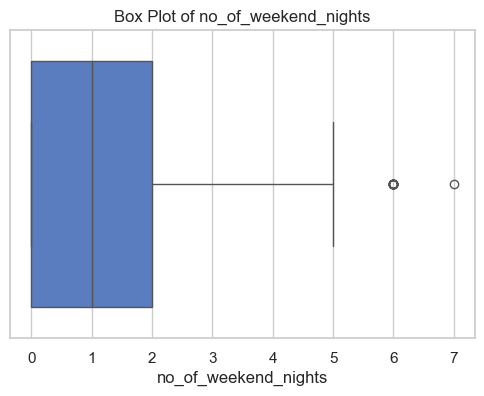

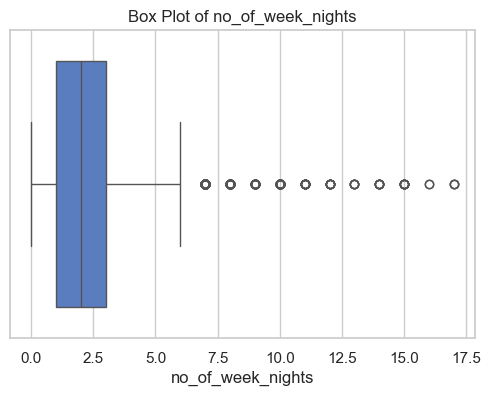

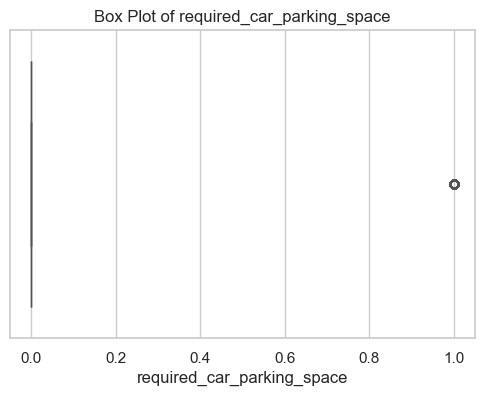

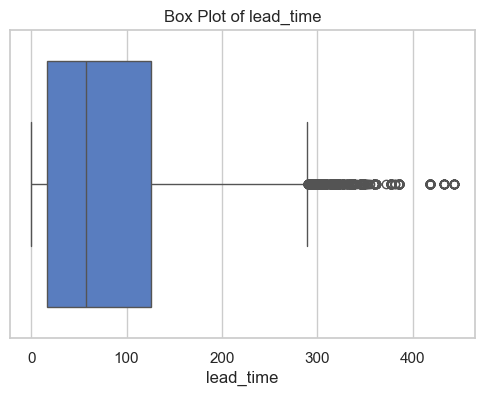

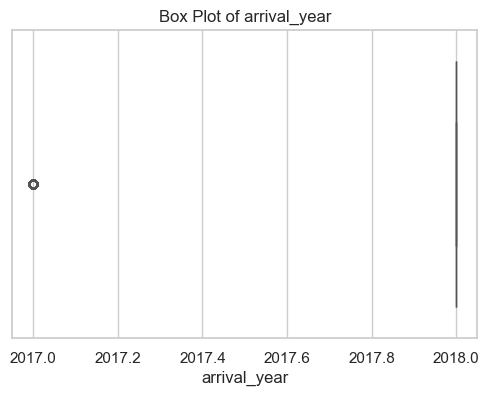

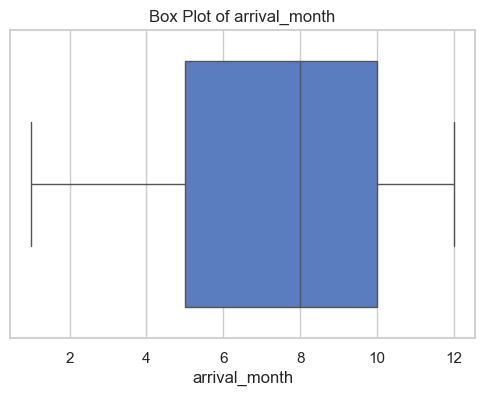

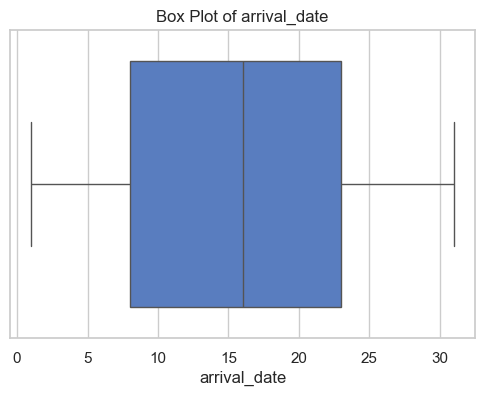

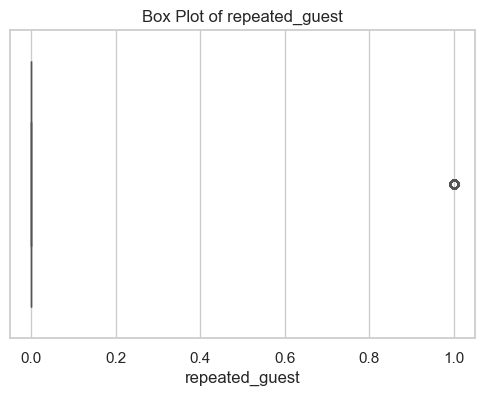

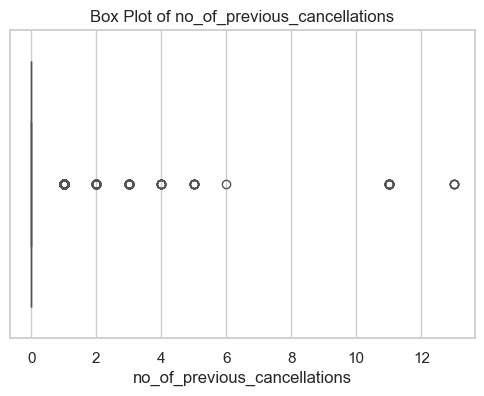

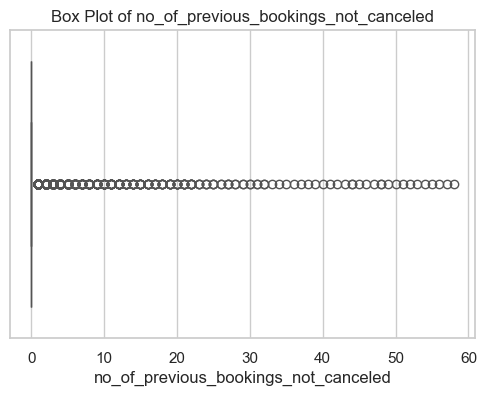

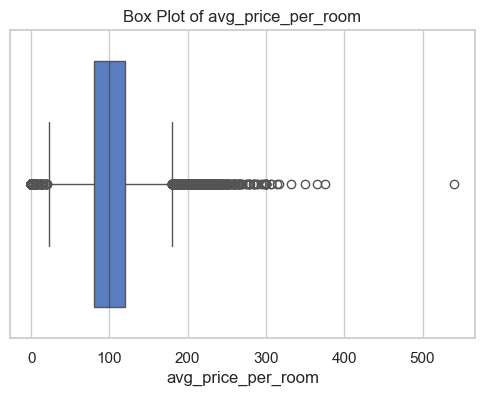

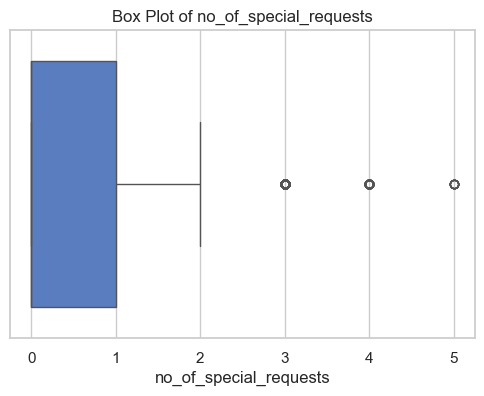

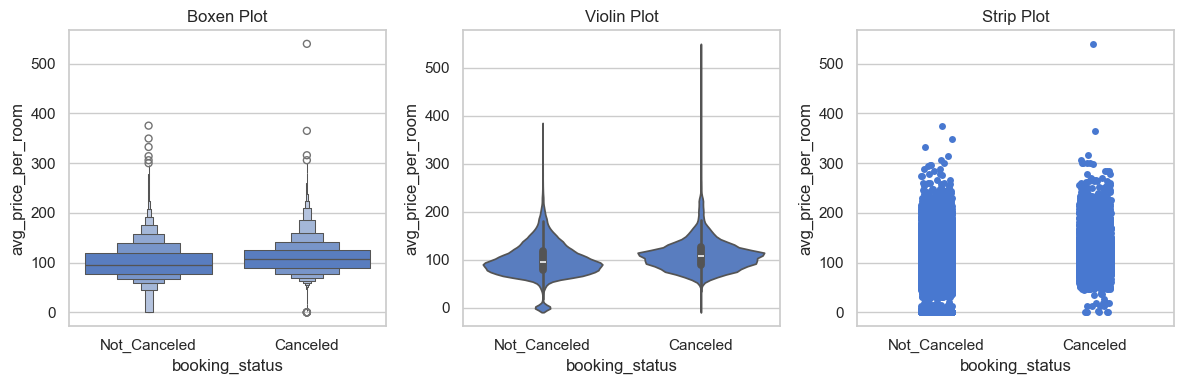

In [5]:
# Numeric columns for analysis
numeric_df = df.select_dtypes(include=[np.number])

# Histogram of numeric columns
numeric_columns = numeric_df.columns.tolist()
for col in numeric_columns:
    plt.figure(figsize=(6,4))
    sns.histplot(numeric_df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Count plot for the target variable: booking_status
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='booking_status')
plt.title('Count Plot of Booking Status')
plt.xlabel('Booking Status')
plt.ylabel('Count')
plt.show()

# Pair Plot for numeric features (if at least two numeric features exist)
if len(numeric_columns) >= 2:
    sns.pairplot(numeric_df)
    plt.show()

# Correlation Heatmap: Only if four or more numeric columns are present
if len(numeric_columns) >= 4:
    plt.figure(figsize=(10,8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Box Plot for numeric features
for col in numeric_columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=numeric_df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

# Boxen Plot, Violin Plot, and Strip Plot for booking_status vs avg_price_per_room
if 'avg_price_per_room' in df.columns:
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    sns.boxenplot(x='booking_status', y='avg_price_per_room', data=df)
    plt.title('Boxen Plot')

    plt.subplot(1,3,2)
    sns.violinplot(x='booking_status', y='avg_price_per_room', data=df)
    plt.title('Violin Plot')

    plt.subplot(1,3,3)
    sns.stripplot(x='booking_status', y='avg_price_per_room', data=df, jitter=True)
    plt.title('Strip Plot')
    plt.tight_layout()
    plt.show()

Predictive Modelling

Our goal is to predict the booking_status. We craft a Logistic Regression model for a quick baseline. In the process of creating a working dataframe for modelling, we drop the identifier column and the date column that we created. To avoid errors (like trying to drop a nonexistent column), we use the errors='ignore' parameter.

We also convert categorical variables using one-hot encoding.

Test Set Accuracy: 0.8068917987594763


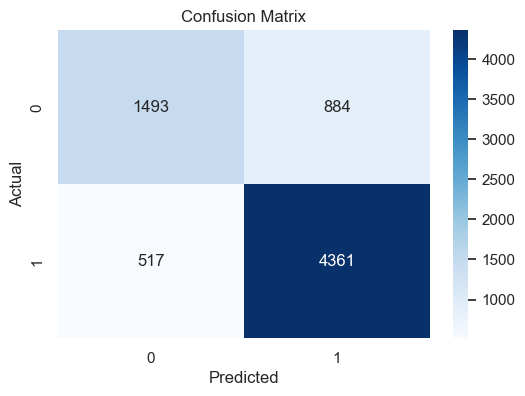

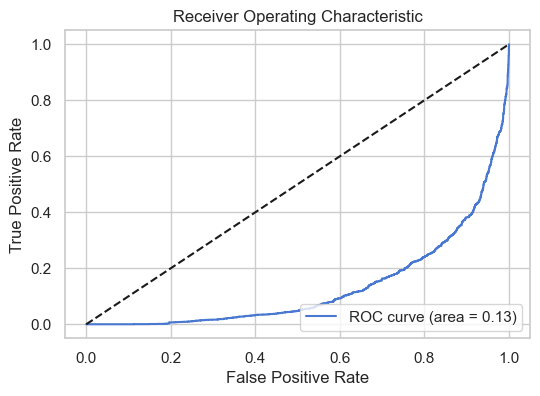

In [6]:
# Predictive Modelling

# Create a working copy of the dataframe
df_model = df.copy()

# Drop identifier and datetime columns if they exist
columns_to_drop = ['Booking_ID', 'arrival_datetime']
df_model.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Separate target and features
y = df_model['booking_status']
X = df_model.drop('booking_status', axis=1)

# Convert categorical variables to one-hot encodings
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Splitting data into training and testing sets with stratification on the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy score of the model
accuracy = accuracy_score(y_test, y_pred)
print('Test Set Accuracy:', accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve computation for binary classification only
if len(y.unique()) == 2:
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=y.unique()[1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()